# Minimizing Kullback-Leibler Divergence

> In this post, we will see how the KL divergence can be computed between two distribution objects, in cases where an analytical expression for the KL divergence is known. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: 

## Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview

### KL divergence

```python
# KL(q || p) = E_{z ~ q}[log q(z) - log p(z)]
```

In [3]:
scale_tril = tfb.FillScaleTriL()([-0.5, 1.25, 1.])
scale_tril

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.3132716, 0.       ],
       [1.25     , 0.474087 ]], dtype=float32)>

In [9]:
p = tfd.MultivariateNormalTriL(loc=0., scale_tril=scale_tril)
p

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

In [10]:
q = tfd.MultivariateNormalDiag(loc=[0., 0.])
q

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [11]:
tfd.kl_divergence(q, p)

<tf.Tensor: shape=(), dtype=float32, numpy=3.056092>

### Another example

In [14]:
q = tfd.MultivariateNormalDiag(
    loc=tf.Variable(tf.random.normal([2])),
    scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]), bijector=tfb.Exp())
)
q

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [15]:
tfd.kl_divergence(q, p)

<tf.Tensor: shape=(), dtype=float32, numpy=2.5613167>

In [16]:
@tf.function
def loss_and_grads(q_dist):
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(q_dist, p)
    return loss, tape.gradient(loss, q_dist.trainable_variables)

In [17]:
optimizer = tf.keras.optimizers.Adam()

for i in range(20):
    loss, grads = loss_and_grads(q)
    optimizer.apply_gradients(zip(grads, q.trainable_variables))
    print(loss)

tf.Tensor(2.5613167, shape=(), dtype=float32)
tf.Tensor(2.5531254, shape=(), dtype=float32)
tf.Tensor(2.544958, shape=(), dtype=float32)
tf.Tensor(2.5368156, shape=(), dtype=float32)
tf.Tensor(2.528698, shape=(), dtype=float32)
tf.Tensor(2.520605, shape=(), dtype=float32)
tf.Tensor(2.5125387, shape=(), dtype=float32)
tf.Tensor(2.504498, shape=(), dtype=float32)
tf.Tensor(2.4964833, shape=(), dtype=float32)
tf.Tensor(2.4884958, shape=(), dtype=float32)
tf.Tensor(2.480536, shape=(), dtype=float32)
tf.Tensor(2.4726028, shape=(), dtype=float32)
tf.Tensor(2.4646974, shape=(), dtype=float32)
tf.Tensor(2.45682, shape=(), dtype=float32)
tf.Tensor(2.4489715, shape=(), dtype=float32)
tf.Tensor(2.4411516, shape=(), dtype=float32)
tf.Tensor(2.4333599, shape=(), dtype=float32)
tf.Tensor(2.425598, shape=(), dtype=float32)
tf.Tensor(2.4178653, shape=(), dtype=float32)
tf.Tensor(2.410162, shape=(), dtype=float32)


## Tutorial

In [18]:
# Define a target distribution, p

tf.random.set_seed(41)

p_mu = [0., 0.]
p_L = tfb.Chain([tfb.TransformDiagonal(tfb.Softplus()),
                 tfb.FillTriangular()])(tf.random.uniform([3]))

p = tfd.MultivariateNormalTriL(loc=p_mu, scale_tril=p_L)

In [19]:
p

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

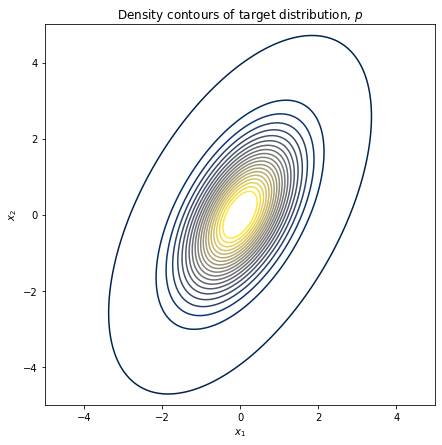

In [20]:
# Plot the target distribution's density contours

def plot_density_contours(density, X1, X2, contour_kwargs, ax=None):
    '''
        Plots the contours of a bivariate TensorFlow density function (i.e. .prob()).
        X1 and X2 are numpy arrays of mesh coordinates.
    '''
    X = np.hstack([X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis]])
    density_values = np.reshape(density(X).numpy(), newshape=X1.shape)
    
    if ax==None:
        _, ax = plt.subplots(figsize=(7, 7))
    
    ax.contour(X1, X2, density_values, **contour_kwargs)
    return(ax)

x1 = np.linspace(-5, 5, 1000)
x2 = np.linspace(-5, 5, 1000)
X1, X2 = np.meshgrid(x1, x2)
f, ax = plt.subplots(1, 1, figsize=(7, 7))

# Density contours are linearly spaced
contour_levels = np.linspace(1e-4, 10**(-0.8), 20) # specific to this seed
ax = plot_density_contours(p.prob, X1, X2, 
                           {'levels':contour_levels, 
                            'cmap':'cividis'}, ax=ax)
ax.set_xlim(-5, 5); ax.set_ylim(-5, 5); 
ax.set_title('Density contours of target distribution, $p$')
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
plt.show()

In [21]:
# Instantiate an approximating distribution, q, that has diagonal covariance

tf.random.set_seed(41)

q = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal([2])),
                               scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]),
                                                                       bijector=tfb.Exp()))
q

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [22]:
# Define a function for the Kullback-Leibler divergence

@tf.function
def loss_and_grads(dist_a, dist_b):
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(dist_a, dist_b)
    return loss, tape.gradient(loss, dist_a.trainable_variables)    

In [23]:
from IPython.display import clear_output

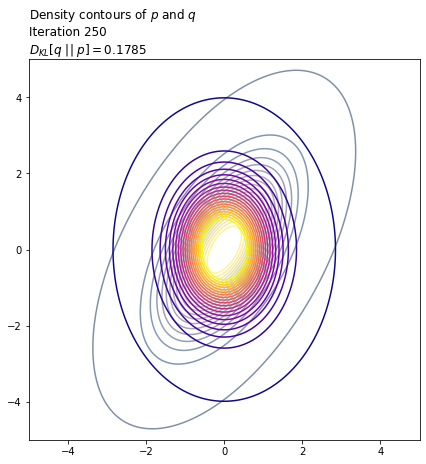

In [30]:
# Run a training loop that computes KL[q || p], updates q's parameters using its gradients

num_train_steps = 250
opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    
    # Compute the KL divergence and its gradients
    q_loss, grads = loss_and_grads(q, p)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[q \ || \ p] = ' + 
                      str(np.round(q_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)
plt.show()

In [31]:
# Re-fit the distribution, this time fitting q_rev by minimizing KL[p || q_rev]
tf.random.set_seed(41)

q_rev = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal([2])),
                                   scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]), bijector=tfb.Exp()))
q_rev

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [32]:
# Edit loss_and_grads function

@tf.function
def loss_and_grads(dist_a, dist_b, reverse=False):
    with tf.GradientTape() as tape:
        if not reverse:
            loss = tfd.kl_divergence(dist_a, dist_b)
        else:
            loss = tfd.kl_divergence(dist_b, dist_a)
    return loss, tape.gradient(loss, dist_a.trainable_variables)

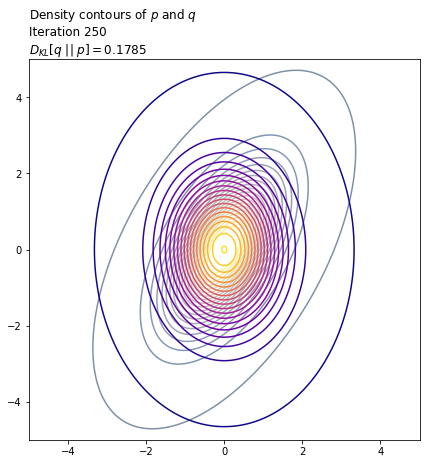

In [33]:
# Run a training loop that computes KL[q || p], updates q's parameters using its gradients

num_train_steps = 250
opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    
    # Compute the KL divergence and its gradients
    q_rev_loss, grads = loss_and_grads(q, p, reverse=True)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[q \ || \ p] = ' + 
                      str(np.round(q_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)
plt.show()

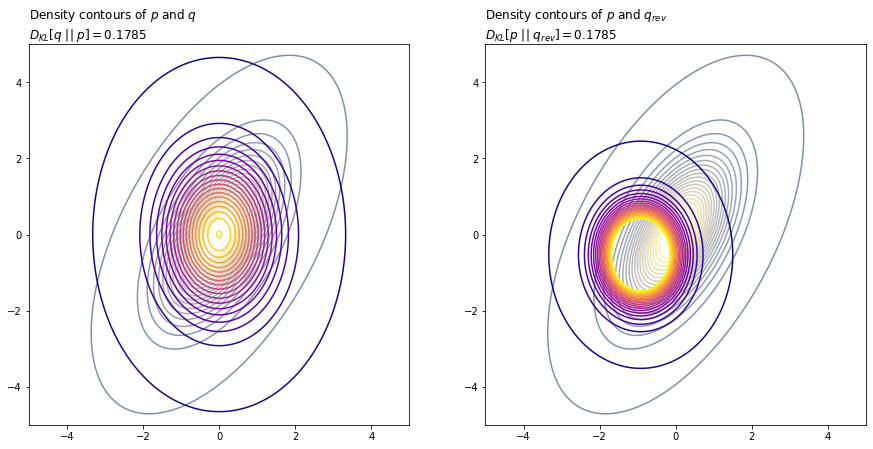

In [34]:
# Plot q and q_rev alongside one another

f, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[0])
axs[0] = plot_density_contours(q.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[0])
axs[0].set_title('Density contours of $p$ and $q$\n' +
              '$D_{KL}[q \ || \ p] = ' + str(np.round(q_loss.numpy(), 4)) + '$',
              loc='left')

axs[1] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[1])
axs[1] = plot_density_contours(q_rev.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[1])
axs[1].set_title('Density contours of $p$ and $q_{rev}$\n' +
              '$D_{KL}[p \ || \ q_{rev}] = ' + str(np.round(q_rev_loss.numpy(), 4)) + '$',
              loc='left')
plt.show()